Inclination Tests
==========
Having already created face-on and inclined profiles, we'll now look at their surface brightness and visibilities.

First load relevant modules

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.integrate import quad
from getVis import getVis
from d3sbModel import d3sbModel
from deprojectVis import deprojectVis

Let's look at the original, high-resolution surface brightness profiles, which were generated using DATA/createmodel.py for a 2D Gaussian with total flux of 0.2 Jy and Rc = 100AU.  The inclined model is at 75 deg.

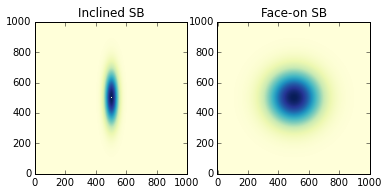

In [2]:
#Input files
facesb = 'DATA/ss_i0_carma.fits' #The face-on profile
origsb = 'DATA/ss_i75_carma.fits' #The inclined surface brightness profile
incldeg = 75. #Inclination angle
incl = np.deg2rad(incldeg)

#Read in files
fopen = fits.open(facesb) #Read in FITS file
#fopen.info() #Check its type
fsb = np.squeeze(fopen[0].data)#Save the dimension of interest and remove extra singleton dimensions
fopen.close()

fopen = fits.open(origsb) #Read in FITS file
#fopen.info() #Check its type
osb = np.squeeze(fopen[0].data)#Save the dimension of interest and remove extra singleton dimensions
fopen.close()

#Plot the images
plt.subplot(122)
plt.imshow(fsb,cmap='YlGnBu', origin='lower')
plt.title('Face-on SB')

plt.subplot(121)
plt.imshow(osb,cmap='YlGnBu', origin='lower')
plt.title('Inclined SB')

We'll come back to plotting the radial profile, and the binned versions of these.  For now, let's plot the visibilities.

[0, 600, -0.05, 0.25]

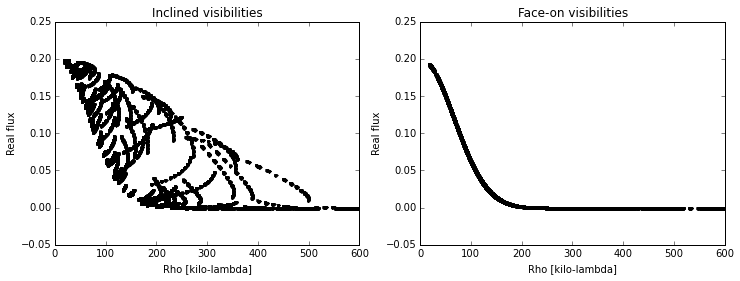

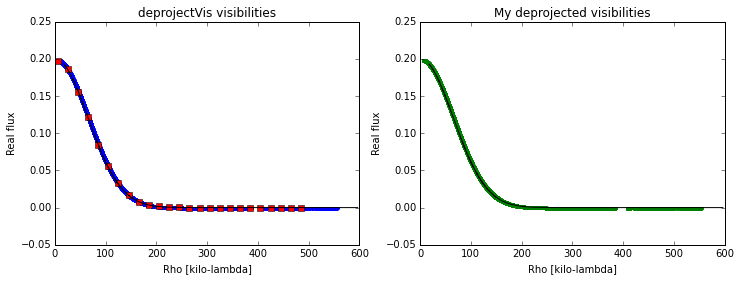

In [4]:
origvis = 'DATA/ss_i75_carma.vis.fits'
facevis = 'DATA/ss_i0_carma.vis.fits'

#Face on data
dataface = getVis(facevis) #Used for CARMA visibilities.
uface, vface, drealface, dimagface, dwgtface = dataface
rhoface = np.sqrt(uface**2 + vface**2)
rind = rhoface.argsort()

#Original, inclined data
dataorig = getVis(origvis) #Used for CARMA visibilities.
uorig, vorig, drealorig, dimagorig, dwgtorig = dataorig
rhoorig = np.sqrt(uorig**2 +vorig**2)

#Data deprojected with deprojectVis
bins = np.arange(5.,500.,20)
visout = deprojectVis(origvis, bins, incl=75, PA = 0, offset=[0.,0.], nu = 225e9, wsc = 1., fitsfile=1)
newbins, newre, newim, newerr, Ruvp, realp = visout

#Data that I deprojected
incl = np.deg2rad(75.)
udeproj = uorig * np.cos(incl) #Deproject
rhodeproj = np.sqrt(udeproj**2+vorig**2)

#Plot visibilities
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].plot(rhoface[rind], drealface[rind], '.k')
ax[1].set_title('Face-on visibilities')
ax[1].set_xlabel('Rho [kilo-lambda]')
ax[1].set_ylabel('Real flux')
ax[1].axis([0, 600, -0.05, 0.25])

ax[0].plot(rhoorig, drealorig, '.k')
ax[0].set_title('Inclined visibilities')
ax[0].set_xlabel('Rho [kilo-lambda]')
ax[0].set_ylabel('Real flux')
ax[0].axis([0, 600, -0.05, 0.25])


#Plot deprojected visibilities
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(Ruvp, realp, '.b')
ax[0].plot(newbins, newre, 'rs') #Binned visibilities
ax[0].plot(rhoface[rind], drealface[rind], 'k')
ax[0].set_title('deprojectVis visibilities')
ax[0].set_xlabel('Rho [kilo-lambda]')
ax[0].set_ylabel('Real flux')
ax[0].axis([0, 600, -0.05, 0.25])

ax[1].plot(rhodeproj, drealorig, '.g')
ax[1].plot(rhoface[rind], drealface[rind], 'k')
ax[1].set_title('My deprojected visibilities')
ax[1].set_xlabel('Rho [kilo-lambda]')
ax[1].set_ylabel('Real flux')
ax[1].axis([0, 600, -0.05, 0.25])

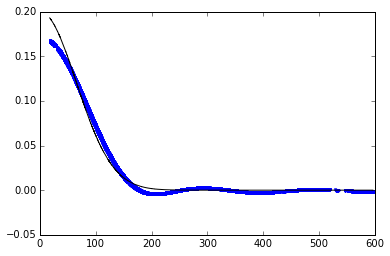

In [12]:
def similarityint(r, rc, ftot, gam):
    '''Similarity soln integrand'''
    return ((2-gam)*ftot/(2*np.pi*rc**2)) * r*(r/rc)**(-gam)*np.exp(-(r/rc)**(2.-gam))

#Binned truth
nbins = 20
dpc = 140.
rin = 0.01/dpc
b = np.linspace(0.05, 1., num=nbins)
a = np.roll(b, 1)
a[0] = rin
cb = 0.5*(a+b)
rout = 100./dpc
Ftot = 0.2
gam = 0.
wtrueint = np.zeros(nbins)
wtruebin = np.zeros(nbins)
for ibin in np.arange(nbins):
    wtrueint[ibin] = 2.*np.pi*quad(similarityint, a[ibin], b[ibin], args=(rout, Ftot, gam))[0]
    wtruebin[ibin] = wtrueint[ibin]/ np.pi/(b[ibin]**2.-a[ibin]**2.)
    
#Truth Visibilities
dbins = rin, b
uvorig = uorig, vorig
uvface = uface, vface

p0deproj = np.concatenate(([incl], wtruebin))
visdeproj = d3sbModel(p0deproj, uvorig, dbins)
p0orig = np.concatenate(([0.], wtruebin))
visorig = d3sbModel(p0orig, uvorig, dbins)
p0face = np.concatenate(([0.], wtruebin))
visface = d3sbModel(p0face, uvface, dbins)


plt.plot(rhoorig, visdeproj, '.')
#plt.plot(rhoorig, visorig, '.k', alpha = 0.1)
#plt.plot(rhoface, visface, '.g', alpha=0.4)
plt.plot(rhoface[rind], drealface[rind], 'k')

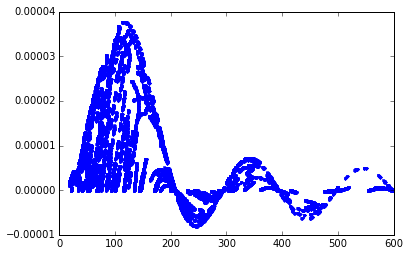

In [7]:
plt.plot(rhoorig, visdeproj-visface, '.')